[View in Colaboratory](https://colab.research.google.com/github/MChamith/SpatioAE/blob/master/trainae.ipynb)

In [3]:
!git clone https://github.com/MChamith/SpatioAE

Cloning into 'SpatioAE'...
remote: Counting objects: 7168, done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 7168 (delta 12), reused 6 (delta 2), pack-reused 7142
Receiving objects: 100% (7168/7168), 275.49 MiB | 30.04 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Checking out files: 100% (7205/7205), done.


In [0]:
import os
os.chdir('SpatioAE')
!pwd
!git pull https://github.com/MChamith/SpatioAE
os.chdir('/content')  
!pwd

In [4]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:

from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras import backend as K
from keras.optimizers import Adam
import cv2
import numpy as np
import os
from tqdm import tqdm
import fnmatch
import scipy.misc
from keras.models import load_model

In [0]:

from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras import backend as K
import cv2
import numpy as np
import os
from tqdm import tqdm
import fnmatch
import scipy.misc
from keras.models import load_model

TRAIN_DIR ='SpatioAE/Train'
TEST_DIR = 'drive/Data/datasets/Test032'
IMG_SIZE = 128



def create_training_set():
  train_data = []
  matches = []
  for root, dirnames, filenames in tqdm(os.walk(TRAIN_DIR)):
    for filename in fnmatch.filter(filenames, "*.tif"):
      path = os.path.join(root, filename)
      img = image.load_img(path, target_size=(128,128), grayscale = True)
      img_array = image.img_to_array(img)
#       print("img array size is " + str(img_array.shape))
#       img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#       img_array = np.expand_dims(img_array, axis = 2)
      train_data.append(np.array(img_array))
          
  np.save('training_data.npy' , train_data)
  
  return train_data

      
    
    
#   for img in tqdm(os.listdir(TRAIN_DIR)):
#     path = os.path.join(TRAIN_DIR, img)
#     img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#     img = np.expand_dims(img, axis = 2)
#     train_data.append(np.array(img))
    
    
#   np.save('training_data.npy' , train_data)
  
#   return train_data


def create_test_set():
  test_data = []
  for img in tqdm(os.listdir(TEST_DIR)):
    path = os.path.join(TEST_DIR, img)
    img = image.load_img(path, target_size=(128,128), grayscale = True)
    img_array =image.img_to_array(img)
    
#     img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE) )
#     img = np.expand_dims(img, axis = 2)
    test_data.append(np.array(img_array))
    
    
  np.save('test_data32.npy' , test_data)
  return test_data

In [0]:
def create_cuboid(input_imgs):
  
  win_size = 8
  m = input_imgs.shape[0]
  h = input_imgs.shape[1]
  w = input_imgs.shape[2]
  c = input_imgs.shape[3]
  
  a = []                                    # a python list to hold the windows
  for i in range(0, input_imgs.shape[0]-win_size+1):
    window = input_imgs[i:i+win_size,:,:,:].reshape((-1,h,w,c)) # each individual window
    a.append(window)
#     print('i = ' + str(i))
   
#   cuboid = np.hstack(a)
  np.save('hyper_cuboid_win8.npy' , a)
  return a

  
  

In [0]:
def create_test_cuboid(input_imgs):
  
  win_size = 8
  m = input_imgs.shape[0]
  h = input_imgs.shape[1]
  w = input_imgs.shape[2]
  c = input_imgs.shape[3]
  
  t = []                                    # a python list to hold the windows
  for i in range(0, input_imgs.shape[0]-win_size+1):
    window = input_imgs[i:i+win_size,:,:,:].reshape((-1,h,w,c)) # each individual window
    t.append(window)
   
#   cuboid = np.hstack(a)
  np.save('test_hyper_cuboid_win8_32.npy' , t)
  return t

In [10]:
create_training_set()
print('started')
input_data = np.load('training_data.npy')
print('training data loaded')
input_data = input_data.astype('float32') / 255
print('data normalized')
create_cuboid(input_data)
print('cuboid created')
img_cuboids = np.load('hyper_cuboid_win8.npy')
print(img_cuboids.shape)


35it [00:06,  5.45it/s]


started
training data loaded
data normalized
cuboid created
(6793, 8, 128, 128, 1)


In [0]:
input_data = np.load('drive/Data/training_data.npy')

In [0]:

input_data = input_data.astype('float32') / 255.
create_cuboid(input_data)

In [0]:
print(img_cuboids.shape)

(6785, 16, 128, 128, 1)


In [0]:
print(img_cuboids.shape)

(6785, 16, 128, 128, 1)


In [0]:

def model_autoencoder():
  
  input_img  = Input(shape = (8,128,128,1))  #channel last
  
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(input_img)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer one conv " + str(x.shape))
  
  x = Conv3D(filters = 48, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2))(x)
  print("layer two conv " + str(x.shape))
  
 
  x = Conv3D(filters = 64, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D(pool_size = (2,2,2), strides = (2,2,2), padding= 'same')(x)
  print("layer three conv " + str(x.shape))
  
  x = Conv3D(filters = 64, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  encoded = MaxPooling3D(pool_size = (1,1,1), strides = (1,1,1))(x)
  print("layer four conv " + str(encoded.shape))
  
  
  ## decoder branch
  
  x = Conv3D(filters = 48, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(encoded)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer one deconv " + str(x.shape))
 
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer two deconv " + str(x.shape))
  
  x = Conv3D(filters = 32, kernel_size = (3,3,3),strides = (1,1,1) , padding ='same' , kernel_initializer = 'glorot_uniform')(x)
  x = UpSampling3D(size = (2,2,2))(x)
  x = BatchNormalization(axis = 4)(x)
  x = Activation('relu')(x)
  print("layer three deconv " + str(x.shape))
  decoded = Conv3D(filters = 1, kernel_size = (3,3,3), strides = (1,1,1), padding = 'same', activation = 'sigmoid')(x)
  print("output" + str(decoded.shape))

  
  
  autoencoder = Model(input_img, decoded)
  
  return autoencoder
  

In [0]:
os.chdir('SpatioAE')
!pwd
!git config --global user.email "charmiemawela02@gmail.com"
!git config --global user.name "MChamith"
!git add hyper_cuboid.npy
!git commit -m "hyper cuboid"
!git push origin master
!pwd
os.chdir('/content')  
!pwd


In [4]:
# create_training_set()
# input_imgs = np.load('training_data.npy')
# create_cuboid(input_imgs)
img_cuboids = np.load('hyper_cuboid_win8.npy')
print("hyper cuboid loaded")
# img_cuboids = img_cuboids.astype('float32') / 255.
print("data normalized")
K.clear_session()
autoencoder = model_autoencoder()
autoencoder.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = ['acc'])
print("model compiled")
autoencoder.fit(img_cuboids,img_cuboids,  epochs =10, batch_size= 32)
print("model fitted")
  
    

hyper cuboid loaded
data normalized
layer one conv (?, 4, 64, 64, 32)
layer two conv (?, 2, 32, 32, 48)
layer three conv (?, 1, 16, 16, 64)
layer four conv (?, 1, 16, 16, 64)
layer one deconv (?, 2, 32, 32, 48)
layer two deconv (?, 4, 64, 64, 32)
layer three deconv (?, 8, 128, 128, 32)
output(?, 8, 128, 128, 1)
model compiled
Epoch 1/10
6793/6793 [==============================] - 385s 57ms/step - loss: 0.0074 - acc: 1.4824e-05
Epoch 2/10
6793/6793 [==============================] - 374s 55ms/step - loss: 0.0050 - acc: 1.6024e-05
Epoch 3/10
6793/6793 [==============================] - 374s 55ms/step - loss: 0.0043 - acc: 1.7720e-05
Epoch 4/10
6793/6793 [==============================] - 374s 55ms/step - loss: 0.0039 - acc: 1.8995e-05
Epoch 5/10
6793/6793 [==============================] - 374s 55ms/step - loss: 0.0036 - acc: 1.9964e-05
Epoch 6/10
6793/6793 [==============================] - 375s 55ms/step - loss: 0.0034 - acc: 2.0579e-05
Epoch 7/10
6793/6793 [==========================

In [0]:
autoencoder.save('3d_autoencoder_model_iter1_win4.h5')



In [0]:
autoencoder.save('drive/Data/3d_autoencoder_model_iter1_win8.h5')

In [52]:
from keras.models import load_model 
K.clear_session()
autoencoder_model = load_model('drive/Data/3d_autoencoder_model_iter3_win8.h5')
# autoencoder_model.summary()

OSError: ignored

In [0]:
autoencoder_model.compile(optimizer = 'adam' , loss = 'mean_squared_error', metrics = ['acc','mae'])
# print("model compiled")
# # autoencoder.fit(img_cuboids,img_cuboids,  epochs =10, batch_size= 32)
# print("model fitted")

In [78]:
print(K.eval(autoencoder_model.optimizer.lr))

0.001


In [12]:
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
history = LossHistory()  
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3 ,min_lr=0.00001)

img_cuboids = np.load('hyper_cuboid_win8.npy')       
model_history = autoencoder_model.fit(img_cuboids,img_cuboids,  epochs =25, batch_size=32, callbacks=[history,reduce_lr],validation_split = 0.1)  
autoencoder_model.save('3d_autoencoder_model_iter3_win8.h5')
autoencoder_model.save('drive/Data/3d_autoencoder_model_win8_iter4.h5')

Train on 6113 samples, validate on 680 samples
Epoch 1/25
6113/6113 [==============================] - 371s 61ms/step - loss: 0.0021 - acc: 2.6981e-05 - val_loss: 0.0011 - val_acc: 9.4245e-06
Epoch 2/25
6113/6113 [==============================] - 364s 59ms/step - loss: 0.0021 - acc: 2.7029e-05 - val_loss: 0.0016 - val_acc: 8.0557e-06
Epoch 3/25
6113/6113 [==============================] - 364s 59ms/step - loss: 0.0021 - acc: 2.7102e-05 - val_loss: 0.0091 - val_acc: 1.1433e-05
Epoch 4/25
6113/6113 [==============================] - 364s 59ms/step - loss: 0.0022 - acc: 2.6884e-05 - val_loss: 0.0019 - val_acc: 1.1063e-05
Epoch 5/25
6113/6113 [==============================] - 364s 59ms/step - loss: 0.0020 - acc: 2.7275e-05 - val_loss: 9.8487e-04 - val_acc: 1.0154e-05
Epoch 6/25
6113/6113 [==============================] - 364s 59ms/step - loss: 0.0020 - acc: 2.7316e-05 - val_loss: 9.6878e-04 - val_acc: 1.0266e-05
Epoch 7/25
6113/6113 [==============================] - 364s 59ms/step - lo

In [0]:
autoencoder_model.save('3d_autoencoder_model_iter2.h5')


NameError: ignored

In [0]:
train_loss = np.array(history.losses)
# train_loss = train_loss[16965-6785:16965]
# train_loss_normed = np.linalg.norm(train_loss)
min_ex = min(train_loss)
max_ex = max(train_loss)

print('minimum loss = ' + str(min_ex) + 'maximum loss= ' + str(max_ex)+ 'train losss = '+str(train_loss.shape))

minimum loss = 0.0006428565maximum loss= 0.0050993245train losss = (1697,)


In [39]:
# get_test_data = create_test_set()
test_imgs = np.load('test_data36.npy')
test_imgs = test_imgs.astype('float32') / 255.
create_test_cuboid(test_imgs)
test_cuboid = np.load('test_hyper_cuboid_win8_36.npy')

print(test_cuboid.shape)




(193, 8, 128, 128, 1)


In [0]:
for i in range(2):
  for j in range(8):
    scipy.misc.imsave('drive/Data/testimage'+str(n)+'.png', np.squeeze(test_cuboid[i][j], axis = 2))
#   sq_img = np.squeeze(test_cuboid[n][1], axis = 2)
#   sq_img = sq_img*255
#   sq_img = sq_img.astype('uint8')

#   dec_img = np.squeeze(decode_imgs[n][1], axis = 2)
#   dec_img = dec_img*255
#   dec_img = dec_img.astype('uint8')

  
#   scipy.misc.imsave('drive/Data/dec'+str(n)+'.png', dec_img)
  

In [0]:
decode_imgs = autoencoder_model.predict(test_cuboid)

In [48]:
print(np.squeeze(decode_imgs[1][1]))
print(np.squeeze(test_cuboid[1][1]))

[[0.3665918  0.31407773 0.4027053  ... 0.33415452 0.15355128 0.2725734 ]
 [0.28767076 0.25165272 0.4176241  ... 0.33526462 0.19010405 0.32217863]
 [0.3285036  0.36008832 0.26042366 ... 0.3353285  0.29230455 0.4493007 ]
 ...
 [0.41672572 0.41849038 0.41418377 ... 0.6470401  0.66060466 0.75101554]
 [0.43709612 0.44734138 0.4424473  ... 0.6860009  0.67404884 0.7712986 ]
 [0.439424   0.4661526  0.475611   ... 0.72254467 0.70244664 0.7338248 ]]
[[0.34901962 0.30588236 0.3882353  ... 0.31764707 0.16078432 0.26666668]
 [0.2509804  0.26666668 0.41568628 ... 0.32156864 0.1764706  0.31764707]
 [0.30980393 0.36862746 0.2627451  ... 0.34117648 0.2784314  0.49803922]
 ...
 [0.40784314 0.4        0.40784314 ... 0.654902   0.6627451  0.7137255 ]
 [0.44705883 0.4627451  0.45490196 ... 0.67058825 0.64705884 0.72156864]
 [0.4627451  0.4627451  0.4745098  ... 0.69411767 0.6666667  0.7372549 ]]


In [0]:
real_img = np.load('test_data.npy')
	diff=x1-x2
	a,b,c,d,e=diff.shape
	n_samples=a*b*c*d*e
	sq_diff=diff**2
	Sum=sq_diff.sum()
	dist=np.sqrt(Sum)
	mean_dist=dist/n_samples

	return mean_dist

In [0]:
def calculate_score(input_img, reconstructed_img):
  diff = input_img - reconstructed_img
  a,b,c=diff.shape
  n_samples=a*b*c
  sq_diff=diff**2
  Sum=sq_diff.sum()
  dist=np.sqrt(Sum)
  mean_dist=dist/n_samples
  return mean_dist
  

In [0]:
def calculate_costs(img_size, win_size):
  
  input_size = img_size+win_size
  costs = np.zeros(img_size+win_size-1, dtype= float)
#   if img_size+win_size > num_input:
#     break
    
  for i in range(0, img_size):
    for k in range(win_size):
      temp = np.squeeze(test_cuboid[i][k])-np.squeeze(decode_imgs[i][k])
      costs[i+k]= np.linalg.norm(temp)
			
  
  np.save('test_costs_win8_iter3_win8_36.npy',costs)
  return costs
    
  
  
  
  

In [0]:
def calculate_costs_tset(img_size, win_size):
  
  input_size = img_size+win_size
  costs = np.zeros(img_size+win_size-1, dtype= float)
#   if img_size+win_size > num_input:
#     break
    
  for i in range(0, img_size):
    for k in range(win_size):
#       temp = np.squeeze(test_cuboid[i][k])-np.squeeze(decode_imgs[i][k])
      temp = calculate_score(test_cuboid[i][k],decode_imgs[i][k])
      costs[i+k]= np.linalg.norm(temp)
			
  
  np.save('test_costs_test.npy',costs)
  return costs
    

In [0]:
print(np.linalg.norm(np.squeeze(decode_imgs[1][2])-np.squeeze(test_cuboid[1][2])))

7.740723


In [42]:
calculate_costs(test_cuboid.shape[0],8)
cost_val = np.load('test_costs_win8_iter3_win8_36.npy')
print(cost_val)


[5.76282263 5.70791912 5.80208206 5.87384939 6.07381344 5.9526372
 5.92053604 6.14933872 6.11261225 6.16212559 6.00901365 6.04444122
 5.93829775 6.0296874  6.11841154 6.1722827  5.97474957 5.92866039
 6.11010647 5.91953993 5.89307308 5.75277042 5.70615673 5.8333683
 5.90384722 6.2070446  6.26275969 6.11730671 6.10752344 6.31683922
 6.41351318 6.30013895 6.45542049 6.60027885 6.5090661  6.50354576
 6.47749138 6.40338469 6.77324295 6.984869   7.02648211 6.7337575
 6.56055593 6.80423164 7.31851292 6.77315712 6.71831465 6.81902218
 6.97134972 6.91001654 6.91539335 6.93933344 7.02991533 7.12908077
 6.94613647 6.8118577  6.61042833 6.66638851 6.60852575 6.97420311
 6.60329771 6.48869228 6.50910807 6.46971464 7.01800156 6.60865545
 6.47950172 6.38847971 6.52735186 6.61356211 6.64756536 6.8576951
 7.20105124 6.06593132 6.56715345 6.5167613  6.10990858 7.08507013
 6.99797535 7.63155937 5.90315628 5.65215731 5.53256702 5.57416344
 5.75255346 5.61812019 5.96663427 5.7911911  5.63055706 5.76348782

In [0]:
print(cost_val)

In [0]:
cost_val1 = np.load('test_costs_win8_iter2.npy')

In [46]:
score = cost_val - min(cost_val)
score = 1 - (score/max(cost_val))
print('maximum score = ' +str(max(score))+ 'min score = ' + str(min(score)))

maximum score = 1.0min score = 0.6727653561740907


In [0]:
score1 = cost_val1 - min(cost_val1)
score1 = 1 - (score1/max(score1)) 

In [44]:
print(score)

[0.7827506  0.80440743 0.76726461 0.7389558  0.66007945 0.70787774
 0.72054013 0.63028831 0.64477516 0.62524449 0.6856399  0.6716654
 0.71353397 0.67748508 0.64248761 0.62123799 0.69915546 0.71733545
 0.64576357 0.72093305 0.73137296 0.78671572 0.80510261 0.75492367
 0.72712308 0.60752607 0.58554911 0.64292342 0.64678245 0.56421729
 0.52608399 0.57080476 0.50955354 0.45241378 0.48839289 0.49057041
 0.50084763 0.53007921 0.38418764 0.30071119 0.28429679 0.39976278
 0.46808259 0.37196407 0.16910447 0.3842215  0.40585425 0.3661299
 0.3060439  0.33023694 0.32811604 0.31867281 0.28294254 0.24382647
 0.31598933 0.36895595 0.44841029 0.42633665 0.44916077 0.30491838
 0.45122299 0.4964294  0.48837634 0.50391518 0.28764196 0.44910961
 0.50005464 0.53595851 0.48118003 0.44717417 0.43376149 0.35087527
 0.21543754 0.66318858 0.46548018 0.4853575  0.64584163 0.26118659
 0.29554135 0.04562247 0.72739562 0.82640282 0.87357553 0.85716771
 0.7868013  0.83982885 0.70235656 0.77156058 0.8349231  0.782488

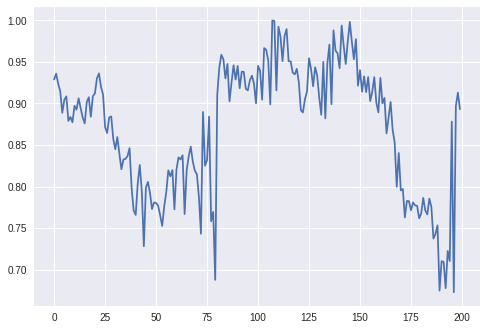

In [47]:
import matplotlib.pyplot as plt
# plt.plot(score1)
plt.plot(score)
# plt.legend(['epoch 47', 'epoch 35'], loc='upper left')
plt.show()


In [0]:
import matplotlib.pyplot as plt
from PIL import Image

for n in range(100,125):
  sq_img = np.squeeze(test_cuboid[n][1], axis = 2)
  sq_img = sq_img*255
  sq_img = sq_img.astype('uint8')

  dec_img = np.squeeze(decode_imgs[n][1], axis = 2)
  dec_img = dec_img*255
  dec_img = dec_img.astype('uint8')

  scipy.misc.imsave('drive/Data/testimage'+str(n)+'.png', sq_img)
  scipy.misc.imsave('drive/Data/dec'+str(n)+'.png', dec_img)


# plt.imshow(sq_img)

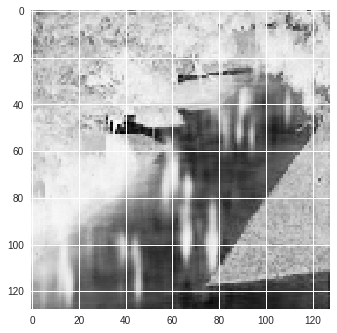

In [0]:
plt.imshow(np.squeeze(decode_imgs[1][1], axis = 2))
  

In [75]:
autoencoder_model.evaluate(test_cuboid, test_cuboid)


193/193 [==============================] - 4s 21ms/step


[0.00776640931385632, 1.1977754108646373e-05, 0.05647316436075794]

In [0]:
import pydot
import graphviz
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png',show_shapes=True)

In [0]:
!apt-get install -q graphviz

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.38.0-16ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
